In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageChops

In [5]:
symbol = 'major'
image_path = f'../../flux-inpaint/symbol_assets/{symbol}.png'
mask_output_path = f'../../flux-inpaint/masks/{symbol}_mask.jpg'

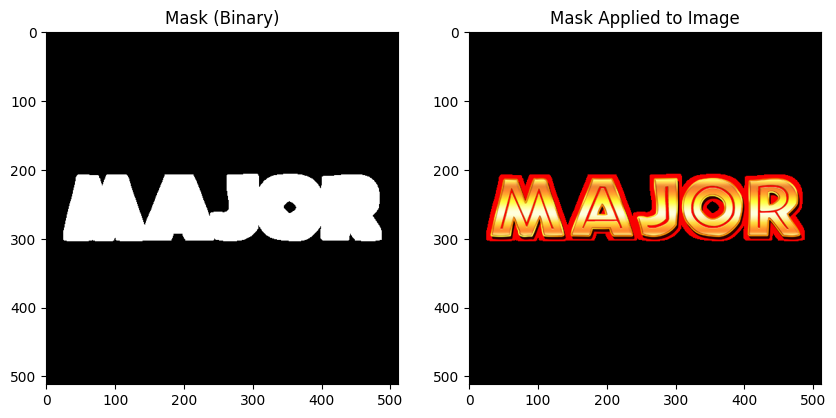

In [6]:
image = cv2.imread(image_path)

# Convert the image to RGB (from BGR, which OpenCV uses by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define a broader color range for the text in HSV
# Adjust these values to match the color of the text more accurately
lower_color = np.array([15, 50, 50])
upper_color = np.array([40, 255, 255])

# Create a mask to isolate the text
mask = cv2.inRange(hsv_image, lower_color, upper_color)

# Apply morphological operations to clean up the mask
kernel = np.ones((7, 7), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=2)
# mask = cv2.erode(mask, kernel, iterations=2)

# Convert the mask to a three-channel RGB image for easier use
mask_rgb = cv2.merge([mask, mask, mask])

# Display the final mask and the masked image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Mask (Binary)')
plt.imshow(mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Mask Applied to Image')
masked_image = cv2.bitwise_and(image_rgb, mask_rgb)
plt.imshow(masked_image)

plt.show()

In [7]:
cv2.imwrite(mask_output_path, mask)

print(f"Mask saved at {mask_output_path}")

Mask saved at ../../flux-inpaint/masks/major_mask.jpg


In [36]:
def restore_inner_opacity_cv2(img_path: str, save_path: str) -> None:
    # Open the image and convert it to RGBA
    im = Image.open(img_path).convert("RGBA")
    np_image = np.array(im)

    # Separate the alpha channel
    alpha_channel = np_image[:, :, 3]

    # Create a binary mask where opaque pixels are 255 and transparent pixels are 0
    _, binary_mask = cv2.threshold(alpha_channel, 200, 255, cv2.THRESH_BINARY)

    # Define a kernel for morphological operations
    kernel = np.ones((3, 3), np.uint8)

    # Apply closing (dilation followed by erosion) to fill inner transparent areas
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Replace the alpha channel in the original image with the modified mask
    np_image[:, :, 3] = closed_mask

    # Convert back to a PIL image and save
    result_image = Image.fromarray(np_image)
    result_image.save(save_path, "PNG")

In [32]:
symbol = 'minor'
image_path = f'../../tmp/prize_words/first_stage/{symbol.upper()}.png'
mask_output_path = f'../../flux-inpaint/masks/{symbol}_mask2.jpg'

In [37]:
restore_inner_opacity_cv2(image_path, mask_output_path)

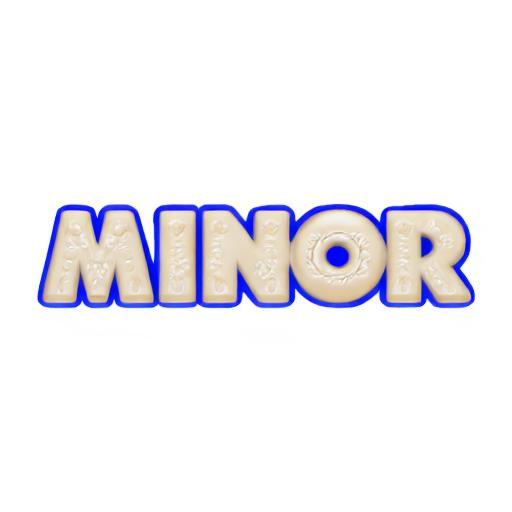

In [38]:
Image.open(mask_output_path)

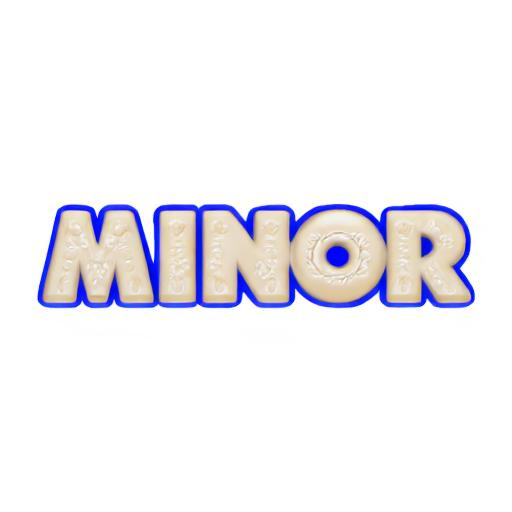

In [39]:
Image.open(image_path)

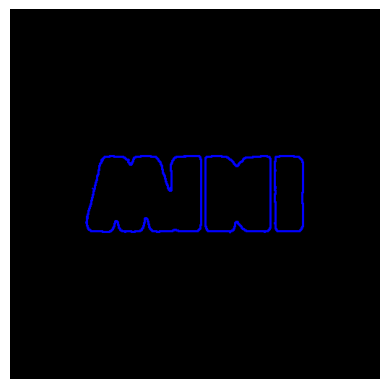

In [67]:

symbol = 'mini'
image_path = f'../../tmp/prize_words/first_stage/{symbol.upper()}.png'
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to get a binary image
_, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)  # Adjust threshold if necessary

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on a blank image
contour_image = np.zeros_like(image)
cv2.drawContours(contour_image, contours, -1, (255, 0, 0), 2)  # Draw in blue with thickness of 2

# Display the contour image
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Save the contour image
# cv2.imwrite('/mnt/data/contour_image.png', contour_image)

In [72]:
def save_contour_with_transparency(img_path: str, save_path: str):
    # Load the image with OpenCV
    image = cv2.imread(img_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to get a binary image
    _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)  # Adjust threshold if necessary

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask of the same size as the image, filled with 0 (transparent)
    mask = np.zeros_like(gray, dtype=np.uint8)

    # Draw the contour on the mask with white (255) to fill inside the contour
    cv2.drawContours(mask, contours, -1, color=255, thickness=cv2.FILLED)
    plt.imshow(mask)
    
    # Convert the original image to RGBA (to add an alpha channel)
    pil_image = Image.open(img_path).convert('RGBA')
    data = pil_image.getdata()

    # Create a new data list for the image with transparency based on the mask
    new_data = []
    for i, item in enumerate(data):
        x = i % pil_image.width
        y = i // pil_image.width

        # Check if the pixel is inside the contour (opaque) or outside (transparent)
        if mask[y, x] == 255:
            new_data.append(item)  # Keep the original color and alpha inside the contour
        else:
            new_data.append((item[0], item[1], item[2], 0))  # Set alpha to 0 outside the contour

    # Update the image with the new data
    pil_image.putdata(new_data)

    # Save the image as PNG with transparency
    pil_image.save(save_path, 'PNG')


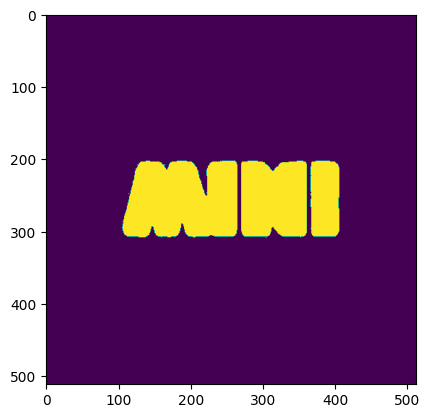

In [73]:
save_contour_with_transparency(image_path, mask_output_path)